# ARIMA on FOREX

1. It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
2. Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. 

In [52]:
import pandas as pd
import numpy as np
from numpy import log
import matplotlib.pylab as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
from matplotlib import pyplot
%matplotlib inline
from matplotlib.pylab import rcParams
import pandas_profiling
rcParams['figure.figsize'] = 15, 6

/Users/Amit/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/Amit/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Amit/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Amit/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
   

## Parameters
header=0: We must specify the header information at row 0.

parse_dates=[0]: We give the function a hint that data in the first column contains dates that need to be parsed. This argument takes a list, so we provide it a list of one element, which is the index of the first column.

index_col=0: We hint that the first column contains the index information for the time series.

squeeze=True: We hint that we only have one data column and that we are interested in a Series and not a DataFrame.

In [2]:
series = Series.from_csv('../0.Data/ukus.csv', header=0)
ts = series

## Types of Stationary Time-series
The notion of stationarity comes from the theoretical study of time series and it is a useful abstraction when forecasting.
There are some finer-grained notions of stationarity that you may come across if you dive deeper into this topic.
They are:

Stationary Process: A process that generates a stationary series of observations.
Stationary Model: A model that describes a stationary series of observations.
Trend Stationary: A time series that does not exhibit a trend.
Seasonal Stationary: A time series that does not exhibit seasonality.
Strictly Stationary: A mathematical definition of a stationary process, specifically that the joint distribution of observations is invariant to time shift.

## Why make your time series stationary?

If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.

If we fit a stationary model to data, we assume our data are a realization of a stationary process. So our first step in an analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them.

Statistical time series methods and even modern machine learning methods will benefit from the clearer signal in the data.

## Checks for Stationarity
There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

1) Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.<br/>
2) Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.<br/>
3) Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

## Non-Stationary Time Series
### Looking at plots
Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.

Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

Text(0,0.5,'US-IND Price')

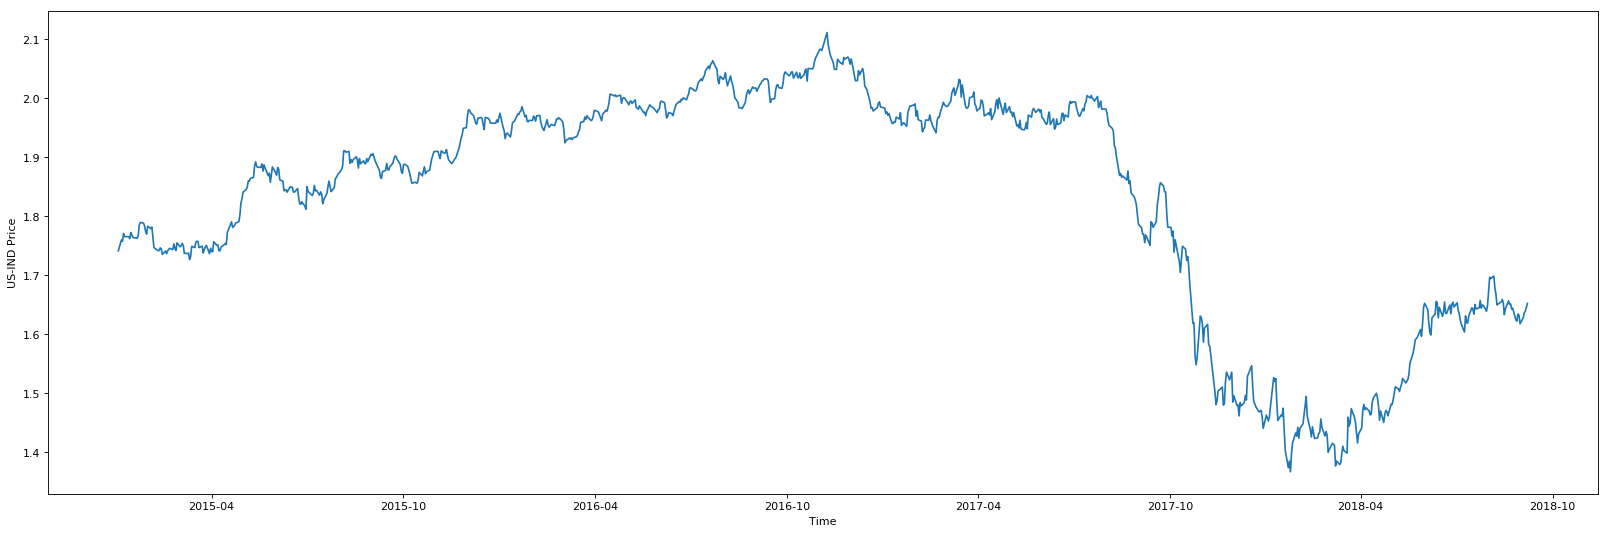

In [3]:
fig=plt.figure(figsize=(25,8),dpi=80,facecolor ='w', edgecolor='k')
ax=fig.add_subplot(111)
ax.plot(series)
ax.set_xlabel('Time')
ax.set_ylabel('US-IND Price')

The above plot is time v/s US-IND exchange rate. We can look at graph and say that it do possess some trends and seasonality occuring which makes it a non-stationary time series. In order to conform that it is non stationary we will take strong staticticsl values into consideration and show methods to convert a non-stationary to a stationary time series.

### Summary Statistics
A quick and dirty check to see if your time series is non-stationary is to review summary statistics.You can split your time series into two (or more) partitions and compare the mean and variance of each group. If they differ and the difference is statistically significant, the time series is likely non-stationary.

Because we are looking at the mean and variance, we are assuming that the data conforms to a Gaussian (also called the bell curve or normal) distribution.We can also quickly check this by eyeballing a histogram of our observations.

/Users/Amit/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Amit/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


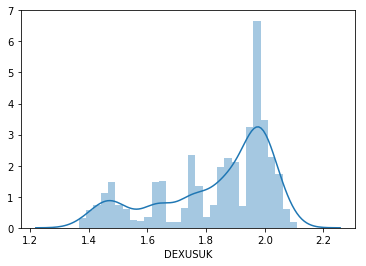

In [4]:
# series.hist()
# pyplot.show()
import seaborn as sns
sns.distplot(series, bins=30)

We can see a bimodal distribution with peaks at 65 & 67.Such distribution of the observations may be another indicator of a non-stationary time series.Reviewing the plot of the time series again, we can see that there is an obvious seasonality/trend component.  

Next, we can split the time series into two contiguous sequences. We can then calculate the mean and variance of each group of numbers and compare the values.

In [5]:
X = series.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1.912862, mean2=1.751739
variance1=0.008796, variance2=0.051355


It shows that the mean and variance values are different, but in the same ball-park. Although in same ball-park as the distribution from previous graph is not gaussian mean and variance makes less sence so we cannot conclude this as stationary.

A log transform can be used to show stationary relationship.

/Users/Amit/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Amit/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


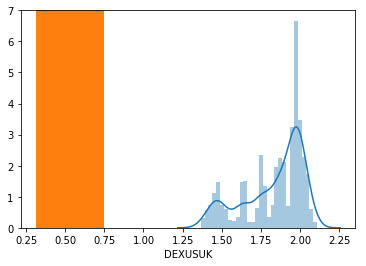

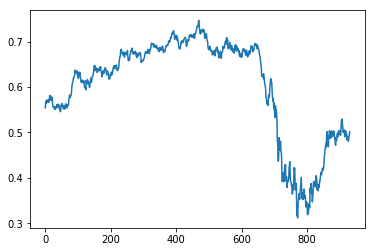

In [6]:
X = series.values
sns.distplot(series, bins=30)
X = log(X)
pyplot.hist(X)
pyplot.show()
pyplot.plot(X)
pyplot.show()

In [7]:
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.647379, mean2=0.552048
variance1=0.002464, variance2=0.017315


Above results shows mean and standard deviation values for each group that are again similar, but not identical.Perhaps, from these numbers alone, we would say the time series is stationary.

This is a quick and dirty method that may be easily fooled.

We can use a statistical test to check if the difference between two samples of Gaussian random variables is real or a statistical fluke. 

## How to make a Time Series Stationary?

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

### Augmented Dickey-Fuller test

Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

#### The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br/>
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


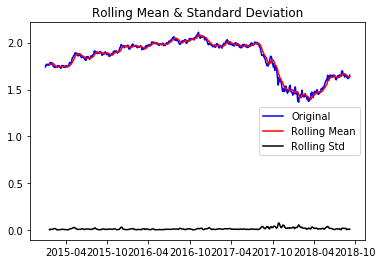

Results of Dickey-Fuller Test:
Test Statistic                  -0.954218
p-value                          0.769594
#Lags Used                      15.000000
Number of Observations Used    915.000000
Critical Value (1%)             -3.437517
Critical Value (5%)             -2.864704
Critical Value (10%)            -2.568455
dtype: float64


In [9]:
test_stationarity(ts)

The test statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary).

Comparing the test statistic to the critical values, it looks like we would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure.

By plotting Rolling Statistics we can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

# Estimating & Eliminating Trend
Let’s log transform the dataset again to make the distribution of values more linear and better meet the expectations of this statistical test.

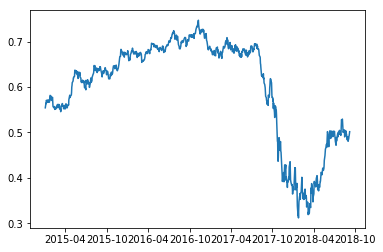

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [11]:
ts_log.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-16',
               ...
               '2018-08-24', '2018-08-27', '2018-08-28', '2018-08-29',
               '2018-08-30', '2018-08-31', '2018-09-03', '2018-09-04',
               '2018-09-05', '2018-09-07'],
              dtype='datetime64[ns]', name='date', length=931, freq=None)

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


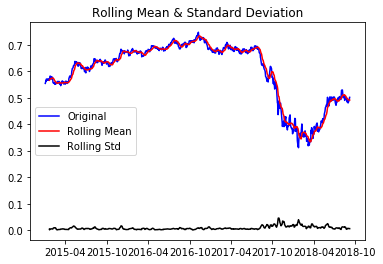

Results of Dickey-Fuller Test:
Test Statistic                  -1.049033
p-value                          0.734963
#Lags Used                      16.000000
Number of Observations Used    914.000000
Critical Value (1%)             -3.437525
Critical Value (5%)             -2.864707
Critical Value (10%)            -2.568457
dtype: float64


In [29]:
test_stationarity(ts_log)

This still shows a positive but a little less value for the test statistic.We can see that the value is larger than the critical values, again, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

It is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

1) Aggregation – taking average for a time period like monthly/weekly averages <br/>
2) Smoothing – taking rolling averages<br/>
3) Polynomial Fitting – fit a regression model<br/>
Smoothing refers to taking rolling estimates, i.e. considering the past few instances.

### Moving average

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """Entry point for launching an IPython kernel.


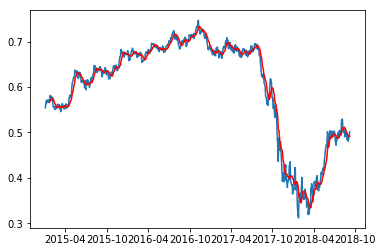

In [13]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 12 days, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values.

In [14]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
2015-01-09         NaN
2015-01-12         NaN
2015-01-13         NaN
2015-01-14         NaN
2015-01-16         NaN
2015-01-19         NaN
2015-01-20    0.000165
Name: DEXUSUK, dtype: float64

In [15]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

date
2015-01-20    0.000165
2015-01-21    0.001485
2015-01-22    0.010373
2015-01-23    0.011281
2015-01-26    0.009836
Name: DEXUSUK, dtype: float64

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


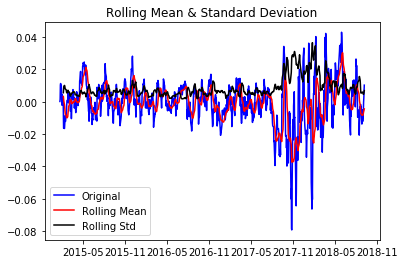

Results of Dickey-Fuller Test:
Test Statistic                  -5.410025
p-value                          0.000003
#Lags Used                      15.000000
Number of Observations Used    904.000000
Critical Value (1%)             -3.437604
Critical Value (5%)             -2.864742
Critical Value (10%)            -2.568475
dtype: float64


In [16]:
test_stationarity(ts_log_moving_avg_diff)

The test statistic value of -4. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.442 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

### Exponential Weighted Moving Average
There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=8,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


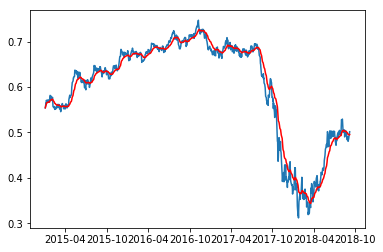

In [17]:
expwighted_avg = pd.ewma(ts_log, halflife=8)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


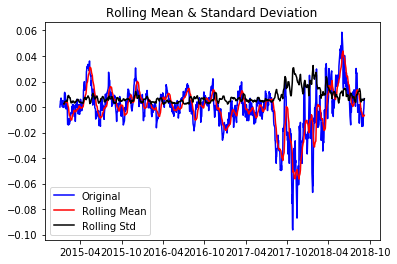

Results of Dickey-Fuller Test:
Test Statistic                  -3.688596
p-value                          0.004276
#Lags Used                      10.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


In [18]:
ts_log_ewma_diff  = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

# Eliminating Trend and Seasonality
There two ways of removing trend and seasonality:

1. Differencing – taking the differece with a particular time lag
2. Decomposition – modeling both trend and seasonality and removing them from the model.

# Differencing
One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

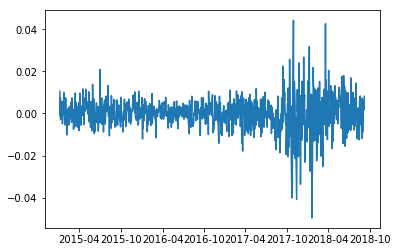

In [19]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


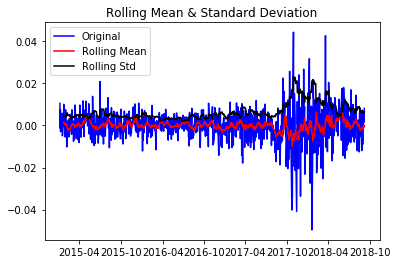

Results of Dickey-Fuller Test:
Test Statistic                -6.102645e+00
p-value                        9.751828e-08
#Lags Used                     1.500000e+01
Number of Observations Used    9.140000e+02
Critical Value (1%)           -3.437525e+00
Critical Value (5%)           -2.864707e+00
Critical Value (10%)          -2.568457e+00
dtype: float64


In [20]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# Decomposing
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned

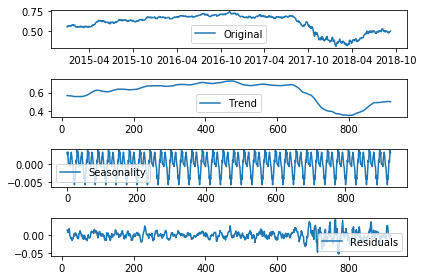

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log.values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """
/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  


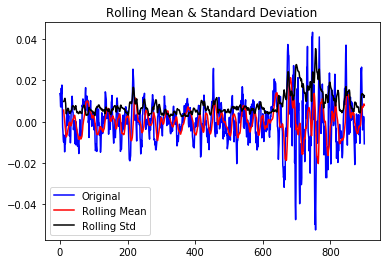

Results of Dickey-Fuller Test:
Test Statistic                -9.141132e+00
p-value                        2.847384e-15
#Lags Used                     2.000000e+01
Number of Observations Used    8.800000e+02
Critical Value (1%)           -3.437803e+00
Critical Value (5%)           -2.864830e+00
Critical Value (10%)          -2.568522e+00
dtype: float64


In [22]:
ts_log_decompose = residual
ts_log_decompose = ts_log_decompose[~np.isnan(ts_log_decompose)]
test_stationarity(ts_log_decompose)

# ARIMA model for Time Series Forecasting

An ARIMA(AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.<br/>
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.<br/>
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.<br/>
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.<br/>
d: The number of times that the raw observations are differenced, also called the degree of differencing.<br/>
q: The size of the moving average window, also called the order of moving average.<br/>

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

## Determining value of ‘p’ and ‘q’

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).<br/> 

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. The ACF and PACF plots for the TS after differencing can be plotted as:

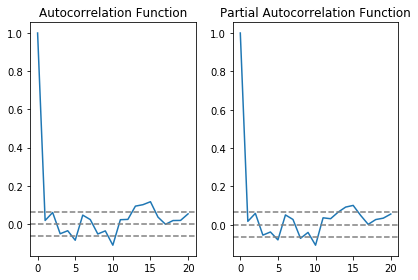

In [23]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Here RSS is for the values of residuals and not actual series.

We need to load the ARIMA model first:

/Users/Amit/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1026: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/Amit/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1029: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/Amit/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1035: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

predicted=0.668736, expected=0.677780
predicted=0.678536, expected=0.680973
predicted=0.685020, expected=0.670032
predicted=0.670189, expected=0.675289
predicted=0.672901, expected=0.666136
predicted=0.662761, expected=0.667624
predicted=0.665451, expected=0.674830
predicted=0.674840, expected=0.670083
predicted=0.672341, expected=0.671413
predicted=0.671778, expected=0.679505
predicted=0.680899, expected=0.679910
predicted=0.683906, expected=0.673404
predicted=0.674146, expected=0.678389
predicted=0.677058, expected=0.676611
predicted=0.676316, expected=0.686777
predicted=0.690240, expected=0.690042
predicted=0.694820, expected=0.688436
predicted=0.692400, expected=0.689641
predicted=0.690223, expected=0.689390
predicted=0.689350, expected=0.684359
predicted=0.683201, expected=0.677881
predicted=0.673821, expected=0.677272
predicted=0.672803, expected=0.683703
predicted=0.683310, expected=0.681935
predicted=0.684010, expected=0.687883
predicted=0.690646, expected=0.689390
predicted=0.

predicted=0.401048, expected=0.390554
predicted=0.386759, expected=0.373768
predicted=0.363015, expected=0.384446
predicted=0.379100, expected=0.371288
predicted=0.366752, expected=0.380831
predicted=0.381411, expected=0.385058
predicted=0.386998, expected=0.383765
predicted=0.387478, expected=0.378916
predicted=0.377806, expected=0.392177
predicted=0.394361, expected=0.391975
predicted=0.396032, expected=0.397500
predicted=0.402685, expected=0.404465
predicted=0.409001, expected=0.412043
predicted=0.418848, expected=0.409656
predicted=0.413706, expected=0.406731
predicted=0.406702, expected=0.411447
predicted=0.411231, expected=0.415085
predicted=0.417466, expected=0.421338
predicted=0.426136, expected=0.416405
predicted=0.418190, expected=0.418381
predicted=0.418643, expected=0.420157
predicted=0.420278, expected=0.425856
predicted=0.429006, expected=0.438319
predicted=0.445313, expected=0.449163
predicted=0.459358, expected=0.455080
predicted=0.464673, expected=0.463231
predicted=0.

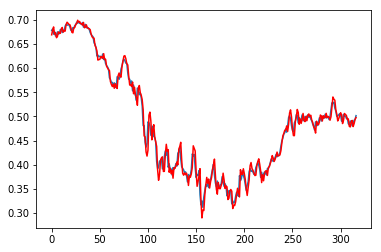

In [28]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = ts_log.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Trading Strategy using Bollinger Band

In [32]:
df = pd.DataFrame(predictions)
df.columns = ['Y_hat_ARIMA']
df.set_index = series.index
df.head()

,Y_hat_ARIMA
0,0.668736
1,0.678536
2,0.685020
3,0.670189
4,0.672901


In [34]:
long_MA = df['Y_hat_ARIMA'].rolling(window=20).mean()
df['Long_Moving_Avg'] = long_MA

In [35]:
short_MA = df['Y_hat_ARIMA'].rolling(window=5).mean()
df['Short_Moving_Avg'] = long_MA

In [36]:
long_std= df['Y_hat_ARIMA'].rolling(window=20).std()
df['Long_std'] = long_std

In [41]:
long_upper_band = ((long_MA) + (long_std)*0.75)
df['Long_Upper_Band'] = long_upper_band
len(long_upper_band)

317

In [42]:
long_lower_band = ((long_MA) - (long_std)*0.75)
df['Long_Lower_Band'] = long_lower_band
len(long_lower_band)

317

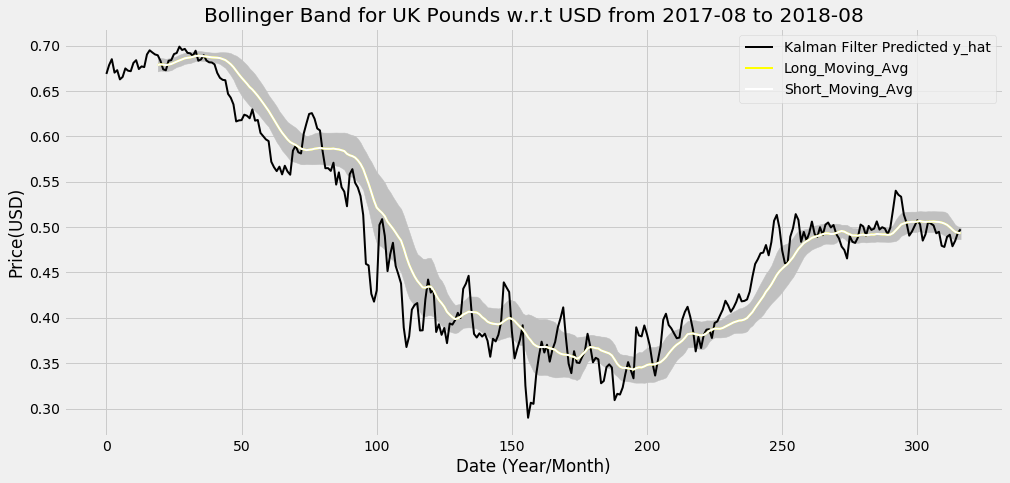

In [44]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = df.index
ax.fill_between(x_axis, df['Long_Upper_Band'], df['Long_Lower_Band'], color='silver')
ax.plot(x_axis, df['Y_hat_ARIMA'], color='black', lw=2, label = 'Kalman Filter Predicted y_hat')
ax.plot(x_axis, df['Long_Moving_Avg'], color='yellow', lw=2)
ax.plot(x_axis, df['Short_Moving_Avg'], color='white', lw=2)

ax.set_title('Bollinger Band for UK Pounds w.r.t USD from 2017-08 to 2018-08')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()

# Trading Strategy using Double Cross-Over

<Figure size 1080x504 with 0 Axes>

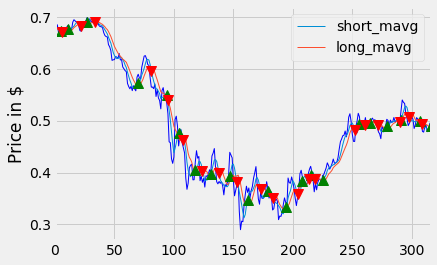

<Figure size 1080x504 with 0 Axes>

In [50]:
ig = plt.figure(figsize=(15,7))
short_window = 5
long_window =10
#df = df.set_index(pd.DatetimeIndex(df['observation_date']))
# Initialize the `signals` DataFrame with the `signal` column
#lowest_Y_hat_bst_avg = lowest_Y_hat_bst_avg.set_index(pd.DatetimeIndex(lowest_Y_hat_bst_avg.index))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
# Create short simple moving average over the short window
signals['short_mavg'] = df['Y_hat_ARIMA'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = df['Y_hat_ARIMA'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:]
                                           > signals['long_mavg'][short_window:], 1.0, 0.0)

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
#print(signals)

# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df['Y_hat_ARIMA'].plot(ax=ax1, color='b', lw=1.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1,lw=1.)
listLongShort = ["No data"]

for i in range(1, len(signals)):
    # If the MACD crosses the signal line upward
   if signals.long_mavg[i] > df['Y_hat_ARIMA'][i] and signals.long_mavg[i - 1] <= df['Y_hat_ARIMA'][i - 1]:
       listLongShort.append("BUY")
    # The other way around
   elif signals.short_mavg[i] < df['Y_hat_ARIMA'][i] and signals.short_mavg[i - 1] >= df['Y_hat_ARIMA'][i - 1]:
       listLongShort.append("SELL")
    # Do nothing if not crossed
   else:
       listLongShort.append("HOLD")

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index,
        signals.short_mavg[signals.positions == 1.0],
        '^', markersize=10, color='g')

# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index,
        signals.short_mavg[signals.positions == -1.0],
        'v', markersize=10, color='r')

fig = plt.figure(figsize=(15,7))
plt.show()

In [53]:
signals['Advice'] = listLongShort
pandas_profiling.ProfileReport(signals)

Number of variables,5
Number of observations,317
Total Missing (%),0.1%
Total size in memory,12.5 KiB
Average record size in memory,40.3 B
Numeric,2
Categorical,1
Boolean,1
Date,0
Text (Unique),0
Rejected,1


# Postions Taken in Forex Market:
- -1 = SELL
- 1 = BUY
- 0 = HOLD

In [54]:
signals['positions'].value_counts()

 0.0    275
 1.0     21
-1.0     20
Name: positions, dtype: int64

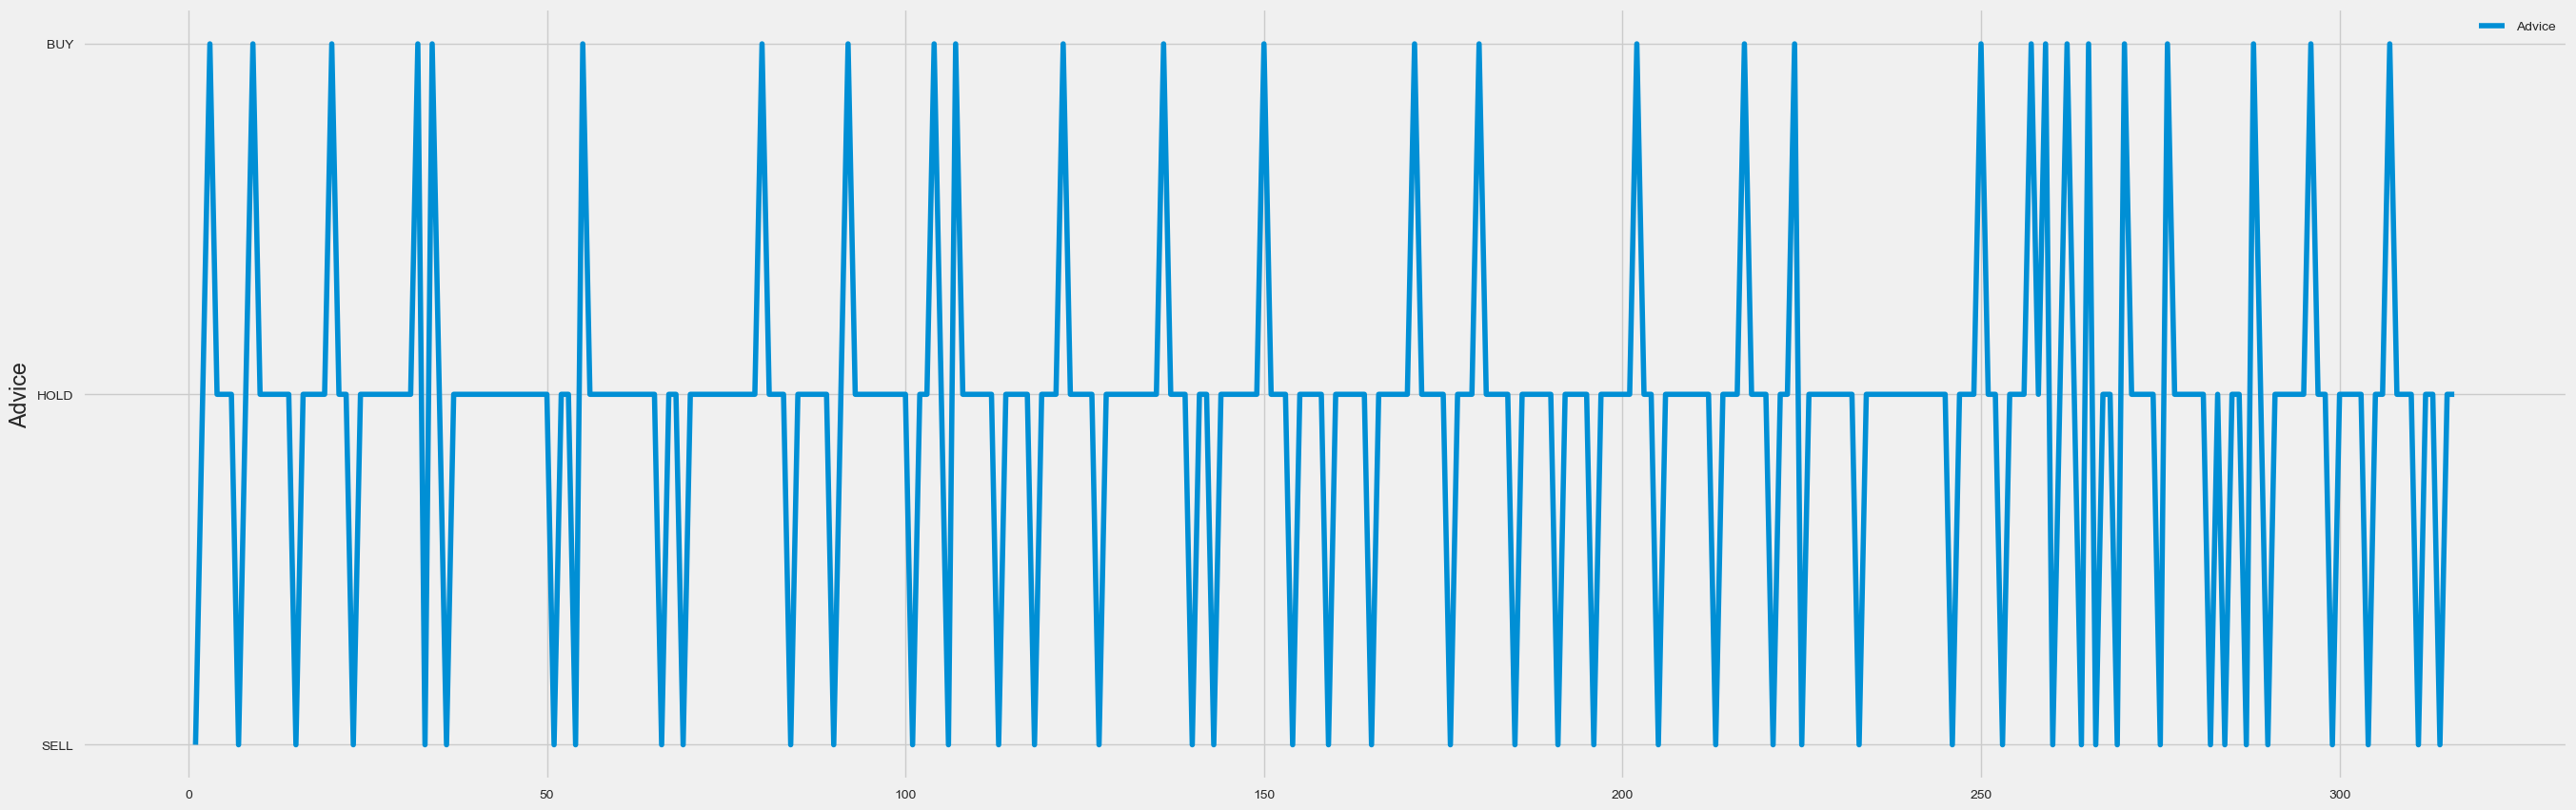

In [55]:
import matplotlib.pyplot as plt
signals = signals[signals.Advice != 'No data']

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)



y_axis=signals.Advice

ax.plot(y_axis)


#ax.set_xlabel('Date (Year)')
ax.set_ylabel('Advice')
ax.legend()
plt.show();

# Calculating Risk Metrics

In [56]:
sell=[]
buy=[]
for i in range(1,len(signals)):
   if signals['positions'].iloc[i]==-1:
       sell.append(signals['long_mavg'].iloc[i])
   elif signals['positions'].iloc[i]==1:
       buy.append(signals['short_mavg'].iloc[i])

In [57]:
profit_loss=[]
for i in range(1,len(sell)):
   profit_loss.append(sell[i]-buy[i])

profit_loss

[0.0072703611173650096,
 0.002538303765140859,
 0.03104647769037172,
 -0.006928786440680401,
 -0.010675854033965038,
 0.0022371309493521285,
 0.00936567919035336,
 0.00016179400993410198,
 0.024910281656271738,
 -0.008144629413718296,
 0.032470878894528266,
 0.006256596088075828,
 -0.005958785819223378,
 0.09622714274659222,
 -0.0007233642766040771,
 -0.0009061138719076434,
 0.008476848021308325,
 0.010628539340798104,
 -0.0026832840764475785]

In [58]:
profit=[]
loss=[]
for i in range(1,len(profit_loss)):
   if profit_loss[i]>0:
       profit.append(profit_loss[i])
   elif profit_loss[i]<0:
       loss.append(profit_loss[i])

In [59]:
GrossLoss=sum(loss)
GrossLoss

-0.03602081793254641

In [60]:
GrossProfit=sum(profit)
NetProfit=GrossProfit+GrossLoss
NetProfit

0.18829885442018024

In [61]:
ProfitFactor=GrossProfit/GrossLoss    #benchmarking
ProfitFactor

-6.2275007961449935

In [64]:
principal = df['Y_hat_ARIMA'].iloc[0]
totalreturn = GrossProfit/principal                  #the profit after the principal amount eg:salary
print('%.2f%%' % (totalreturn*100))

33.54%


In [65]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='tatiya.s', api_key='e9oDZ5ph3cbxFs01p37B')
trace = go.Table(
   header=dict(values=['Risk Metrics', 'Values']),
   cells=dict(values=[['GrossProfit', 'GrossLoss', 'NetProfit','Profit Factor','TotalReturn'],
                      [GrossProfit, GrossLoss, NetProfit,ProfitFactor,(totalreturn*100)]]))


data = [trace]
py.iplot(data, filename = 'basic_table')